In [633]:
import numpy as np
import random
import os, errno
import sys
from tqdm import trange
import pysindy as ps 
import pandas as pd 

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt 
gpuCuda = torch.device('cuda')

In [2]:
data = "SIM_SEC,VEH_ID,POS_LONG,HDWY,ACC,VEL"
df = pd.read_csv('Book5.csv', header=None,low_memory=False, encoding='latin-1')
df = df.rename(columns={0:"SIM_SEC",1:"VEH_ID",2:"LINK",3:"LANE",4:"POS_LONG",5:"HDWY",6:"ACC",7:"SPEED",8:"POS_LAT"})
df = df.drop(['LINK','LANE','POS_LAT'], axis=1)
df = pd.DataFrame(df)

df.iat[0,0] = 0.5
df1 = df["VEH_ID"].value_counts().head(5)
print(df1)

50    10533
25    10533
27    10533
28    10533
29    10533
Name: VEH_ID, dtype: int64


In [3]:
# Initiliazing the numpy arrays and reading in data from the csv file 

x = np.zeros((100,10533,4)) #state measurements 
x_p = np.zeros((100,10533,4)) #state derivatives 

vehID = []
vehStart = []
traj_len = {}
traj_lens = []

for row in df.itertuples():
    if row[2] not in vehID:
        vehID.append(row[2])
        vehStart.append(row[1])
        traj_len[row[2]] = [0]
        time_step = 0
    else:   
        for t_step in range(10533):
            if x[row[2]-1][t_step][1]==0 and x[row[2]-1][t_step][2]==0 and x[row[2]-1][t_step][3]==0:
                traj_len[row[2]].append(t_step)
                time_step = t_step
                break 
    x[row[2]-1][time_step][0] = row[1] #SIM_SEC 
    x[row[2]-1][time_step][1] = row[6] #SPEED
    x[row[2]-1][time_step][2] = row[4] #HDWY=Headway 

    x_p[row[2]-1][time_step][0] = row[1] #SIM_SEC 
    x_p[row[2]-1][time_step][1] = row[5] #SPEED Derivative = ACC
   #x_p[row[2]-1][time_step][2] = row[4] #HDWY Derivative—calculated later using Finite Difference

    if row[0] == 0 or last_row[2] != row[2]-1:
        x[row[2]-1][time_step][2] = 4000 #HDWY reset if leading 
        x[row[2]-1][time_step][3] = 300 #speed reset if leading 
        x_p[row[2]-1][time_step][3] = 0 #not accelerating if leading
        #x_p[row[2]-1][time_step][2] = 0 #HDWY derivative—calculate later using Finite Difference
    else:
        x[row[2]-1][time_step][3] = last_row[6] #leading vehicle speed
        x_p[row[2]-1][time_step][3] = last_row[5] #leading vehicle acceleration 
    last_row = row
    if row[0] == 1048479:
       #print(vehID) 
       #print(vehStart)
        for g in range(len(vehID)):
            traj_lens.append(len(traj_len[g+1]))
       #print(traj_lens)    
        break  

In [663]:
 # Convert data from np arrays to lists for each vehicle

vehNums = [i for i in range(100)]
t = [[] for number in vehNums] #time 
v = [[] for number in vehNums] #velocity 
s = [[] for number in vehNums] #Headway
vlead = [[] for number in vehNums] #leading velocity 
v_p = [[] for number in vehNums] #ACC= v prime 
vlead_p = [[] for number in vehNums] #leading ACC 
v_p_new = [[] for number in vehNums] #ACC= v prime calculated using finite difference  
vlead_p_new = [[] for number in vehNums] #leading ACC calculated using finite difference
s_p = [[] for number in vehNums] #Headway derivatives
x_train_multi = []
x_p_train_multi = []
x_p_train_multi_new = []
vehCount = 0
#print(vehNums)

In [664]:
for vehNo in vehNums:
    for k in range(10532): #10533 changed it to 10532 to avoid the last zero
        if x[vehNo][k][0]==0: #the last few vehicles are less than 10533 time-steps long so truncate those 
            #print(k)
            break
        if k==0 and vehNo!=0: 
            vehCount += 1
        t[vehCount].append(x[vehNo][k][0])  
        v[vehCount].append(x[vehNo][k][1])
        s[vehCount].append(x[vehNo][k][2])
        vlead[vehCount].append(x[vehNo][k][3]) 
        v_p[vehCount].append(x_p[vehNo][k][1])
        vlead_p[vehCount].append(x_p[vehNo][k][3])

In [665]:
ts_length = 2000
v_clust = np.zeros((len(vehNums), ts_length))
s_clust = np.zeros((len(vehNums), ts_length))

for c in range(len(vehNums)): #len(vehNums)
    #if c == 0:
    #    continue
    t[c] = np.asarray(t[c])
    v[c] = np.asarray(v[c])
    s[c] = np.asarray(s[c])
    vlead[c] = np.asarray(vlead[c]) # 2k to 10k
    v_clust[c] = (v[c][2000:4000] - np.mean(v[c][2000:4000])) / np.std(v[c][2000:4000]) # 4k to 6k
    #s_clust[c] = (s[c][2000:4000] - np.mean(s[c][2000:4000])) / np.var(s[c][2000:4000])
    x_train_multi.append(np.stack((v[c][0:],s[c][0:],vlead[c][0:]), axis=-1))
    #print(np.var(v[c][2000:4000]))
    #print(np.var(vlead[c][2000:4000]))

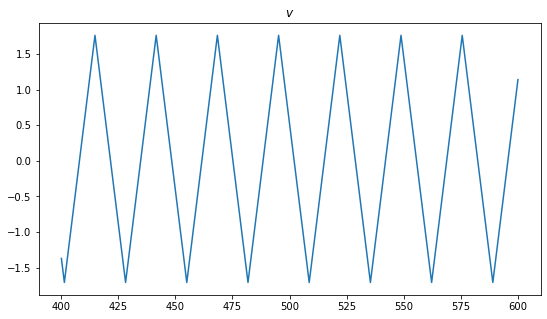

In [666]:
# Plotting the data and original derivatives 
vehCon = 2      # 45, 60, 85, 92 Leader Change 
# 98 Inspect this behavior  
plt.rc('font', size=10)
fig, ax = plt.subplots()
plt.rc({'font.size': 12})
statTraj = 2000  
endsTraj = 4000

fig.set_figheight(5)
fig.set_figwidth(9)
ax.plot(t[vehCon][statTraj:endsTraj], v_clust[vehCon])
ax.set_title('$v$')

plt.show() 

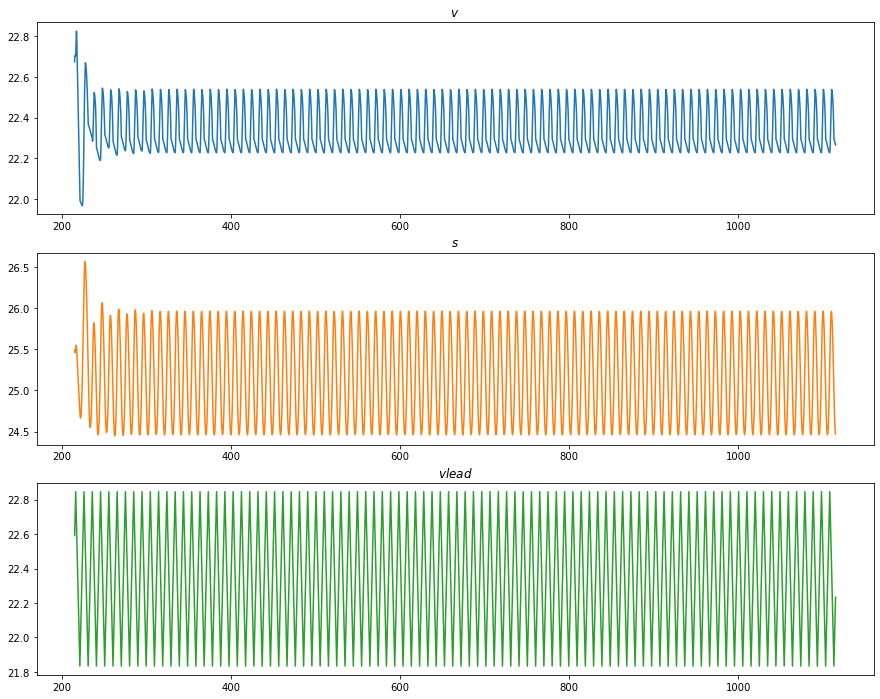

In [667]:
# Plotting the data and original derivatives 
vehCon = 86      # 45, 60, 85, 92 Leader Change 
# 98 Inspect this behavior  
fig, (ax1,ax2,ax3) = plt.subplots(3)
statTraj = 0
endsTraj = 9000

fig.set_figheight(12)
fig.set_figwidth(15)
ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.set_title('$v$')
ax2.plot(t[vehCon][statTraj:endsTraj], s[vehCon][statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[vehCon][statTraj:endsTraj], vlead[vehCon][statTraj:endsTraj], 'tab:green')
ax3.set_title('$vlead$')

plt.show() 

# Clustering 

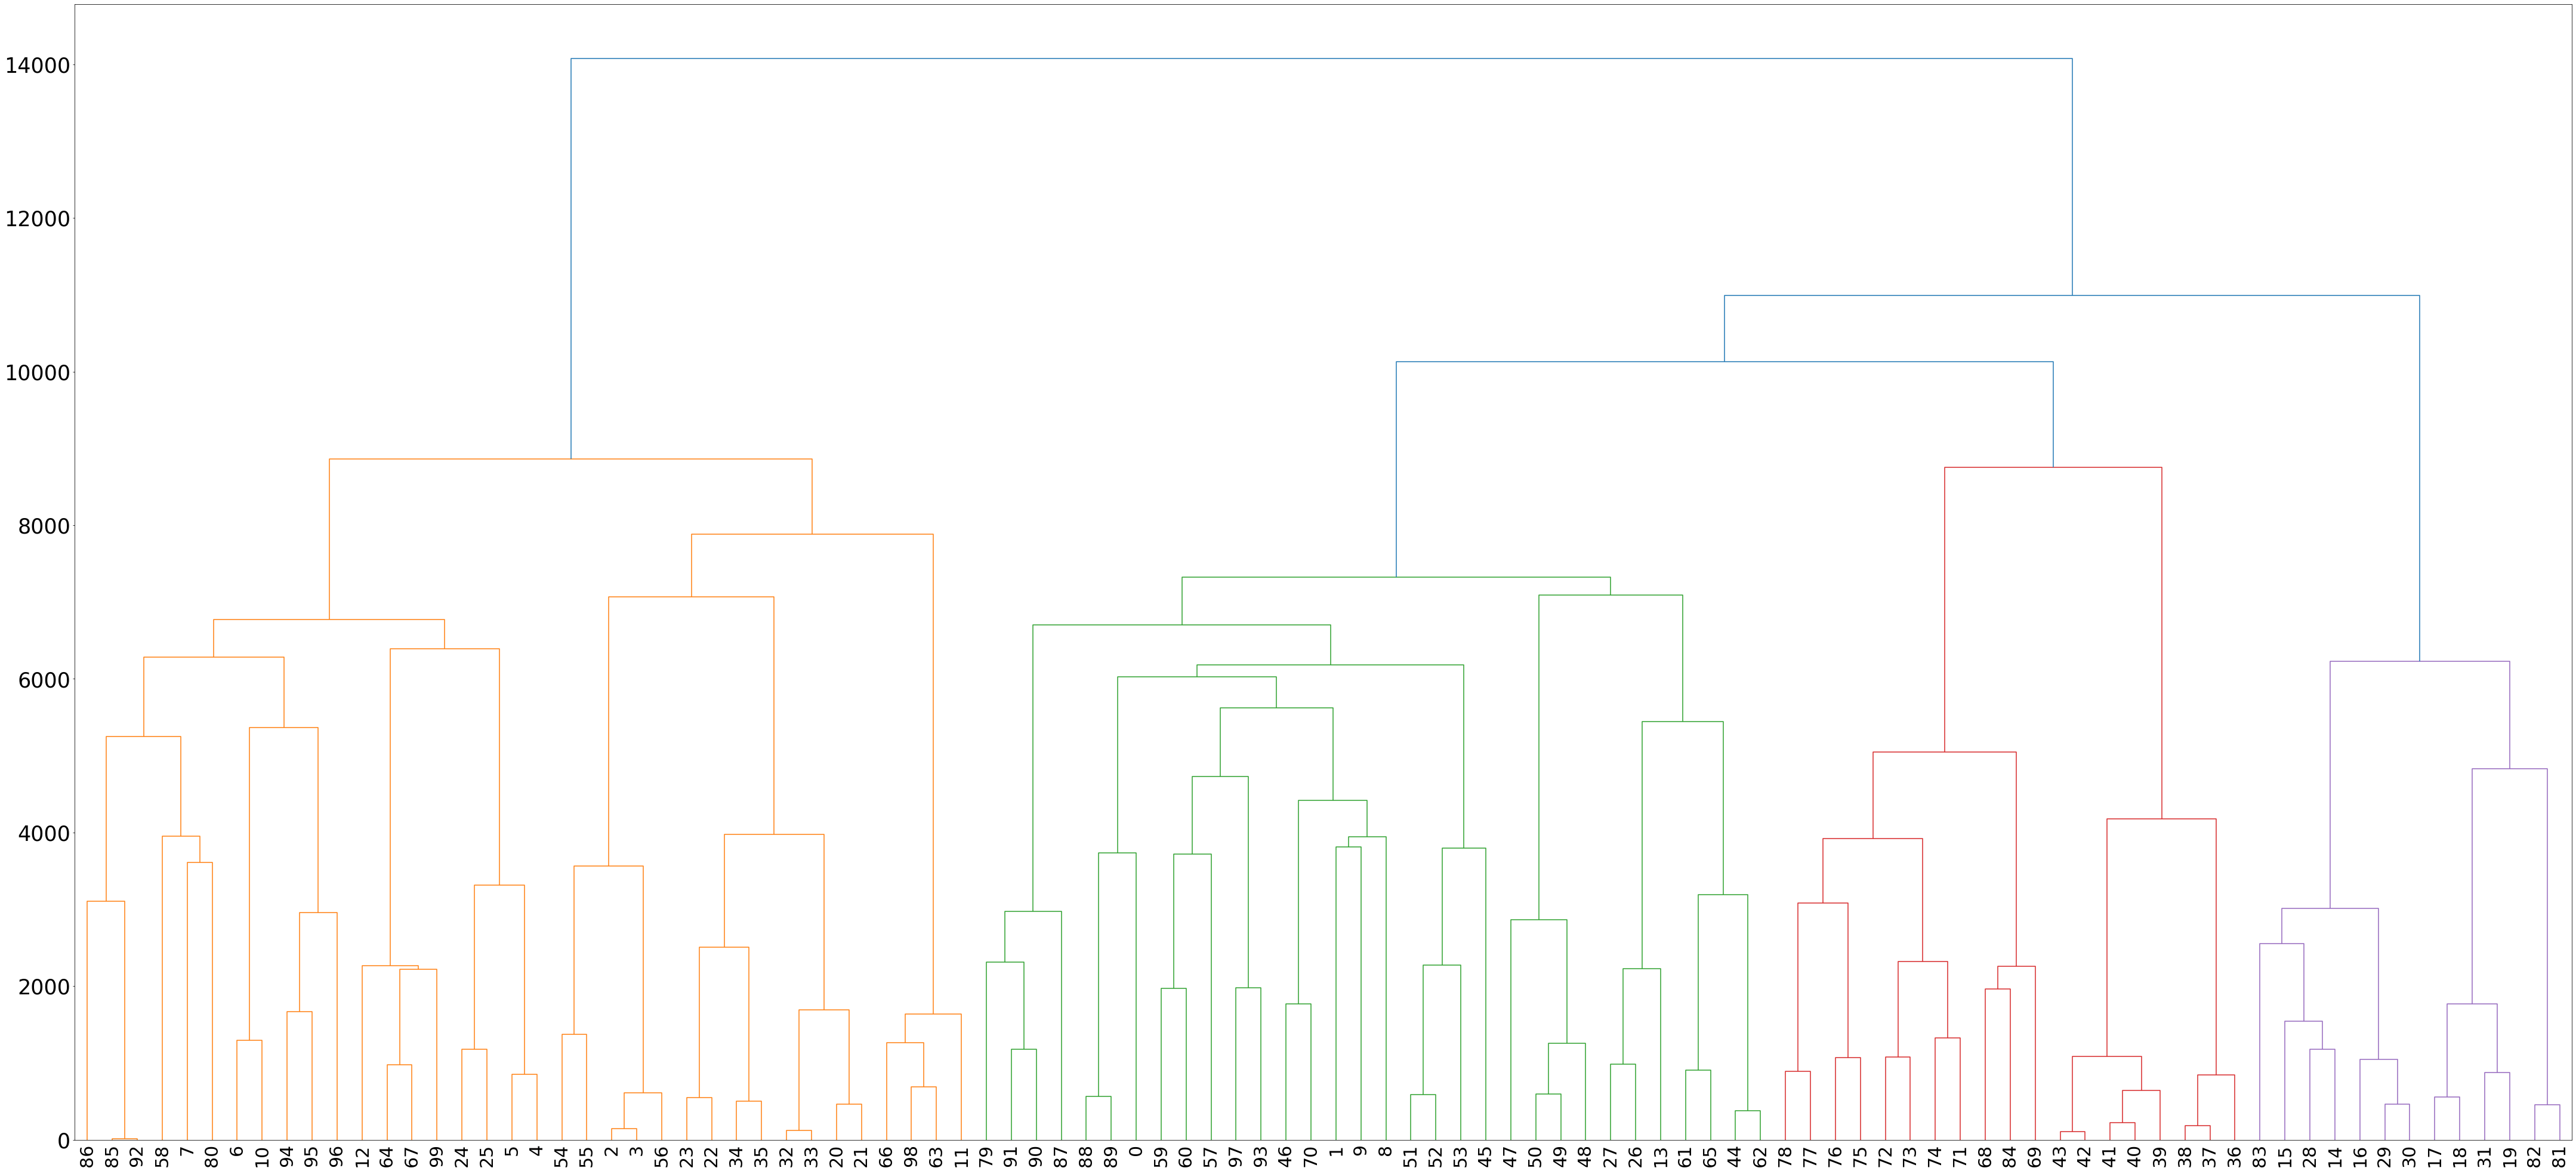

In [821]:
distMatCond = pdist(v_clust, 'sqeuclidean') # Condensed Distance Matrix
distMatRedu = squareform(distMatCond)    # Full nxn Distance Matrix

linkageMat = linkage(distMatCond, method='ward', optimal_ordering=True)
plt.rc('font', size=35)
fig, ax = plt.subplots(figsize=(75, 35))
dn = dendrogram(linkageMat, ax=ax, leaf_font_size=30)
plt.savefig('HierarClust/7.WardLinkage/HCSingleSqEuclidean')
#print(sorted(distMatRedu[28]))

# Encoder 

In [343]:
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        #print(lstm_out.shape) #(80,5,15) HIDDEN states for all time-steps
        #self.hidden's shape should be a tuple  #((1,5,15),(1,5,15)) HIDDEN & CELL state for the last time-step
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed HIDDEN state and CELL state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=gpuCuda),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=gpuCuda)) # ((1,5,15),(1,5,15))

# Decoder 

In [344]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states [Tuple ((1,5,15),(1,5,15))]
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden

# Seq2Seq

In [345]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size):  # No. of Feat. (1) & No. of Hidden Feat. (15)

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size # 1
        self.hidden_size = hidden_size # 15

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size, num_layers = 1)


    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        
        losses = np.full(n_epochs, np.nan) # initialize array of losses 
        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()
        n_batches = int(input_tensor.shape[1] / batch_size) # calculate number of batch iterations
        #print(n_batches) # 60

        with trange(n_epochs) as tr:  # displays progress bar 
            for it in tr:             # run this loop 'n_epochs' times   
                
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches): 
                    input_batch = input_tensor[:, b: b + batch_size, :] # select data # (80,5,1)
                    target_batch = target_tensor[:, b: b + batch_size, :] # All Seq.,Few examples,All Feat. # (20,5,1)

                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2],  device=gpuCuda) # outputs tensor # (20,5,1)
                    # initialize hidden and cell state ((1,5,15),(1,5,15))
                    encoder_hidden = self.encoder.init_hidden(batch_size) 
                    optimizer.zero_grad()  # zero the gradient
                    encoder_output, encoder_hidden = self.encoder(input_batch) # encoder outputs
                    #print(len(encoder_hidden)) # tuple of size 2 ((1,5,15),(1,5,15))

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size) # (5,1) to (1,5,1) after unsqueeze
                    decoder_hidden = encoder_hidden    

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output  # (1,5,1)
                            decoder_input = decoder_output
                        #print(outputs.shape)    # (20,5,1)

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
                    
        return losses

    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1 # (80,1,1)
        encoder_output, encoder_hidden = self.encoder(input_tensor)
        outputs = torch.zeros(target_len, input_tensor.shape[2], device=gpuCuda) # initialize tensor for predictions

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0) # [1,1] to [1]
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().cpu().numpy()
        
        return np_outputs

# Dataset Generation 

In [346]:
def train_test_split(t, y, split = 0.8):

  
  indx_split = int(split * len(y))
  indx_train = np.arange(0, indx_split)
  indx_test = np.arange(indx_split, len(y))
  
  t_train = t[indx_train]
  y_train = y[indx_train] # (1600,)
  y_train = y_train.reshape(-1, 1) # (1600,1) 

  t_test = t[indx_test]
  y_test = y[indx_test] # (400,)
  y_test = y_test.reshape(-1, 1) # (400,1)
  
  return t_train, y_train, t_test, y_test 


def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 3):
  
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1

    X = np.zeros([input_window, num_samples, num_features])   # (80, 301, 1)
    Y = np.zeros([output_window, num_samples, num_features])  # (20, 301, 1)
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff] 

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]

    return X, Y

In [347]:
vehNo = 7
t_train_v, y_train_v, t_test_v, y_test_v = train_test_split(t[vehNo], x_train_multi[vehNo][:, 0]) 
t_train_s, y_train_s, t_test_s, y_test_s = train_test_split(t[vehNo], x_train_multi[vehNo][:, 1]) 
t_train_vl, y_train_vl, t_test_vl, y_test_vl = train_test_split(t[vehNo], x_train_multi[vehNo][:, 2]) 

# Normalization training 
y_train_v = (y_train_v - np.mean(y_train_v)) / np.var(y_train_v)
y_train_s = (y_train_s - np.mean(y_train_s)) / np.var(y_train_s)
y_train_vl = (y_train_vl - np.mean(y_train_vl)) / np.var(y_train_vl)

# Normalization testing
y_test_v = (y_test_v - np.mean(y_test_v)) / np.var(y_test_v)
y_test_s = (y_test_s - np.mean(y_test_s)) / np.var(y_test_s)
y_test_vl = (y_test_vl - np.mean(y_test_vl)) / np.var(y_test_vl)

xTrain = np.stack((y_train_v,y_train_s,y_train_vl), axis=-1).reshape(-1,3) # (8k,3)
xTest = np.stack((y_test_v,y_test_s,y_test_vl), axis=-1).reshape(-1,3) # (2k,3)

In [348]:
# set size of input/output windows 
iw = 500 
ow = 500 
s = 5

# Xtrain(80, 1666, 3) & Ytrain(20, 1666, 3)
# Xtest(80, 402, 3) & Ytest(20, 402, 3)
# generate windowed training/test datasets
Xtrain, Ytrain= windowed_dataset(xTrain, input_window = iw, output_window = ow, stride = s) 
Xtest, Ytest = windowed_dataset(xTest, input_window = iw, output_window = ow, stride = s)
print(Xtrain.shape) 
print(Xtest.shape) 

(500, 1486, 3)
(500, 222, 3)


In [349]:
# LSTM encoder-decoder
# Veh47 [BatchSize(32)|epochs(100)|LR(0.001)|HiddenSize=70]

# convert windowed data from np.array to PyTorch tensor
X_train = torch.from_numpy(Xtrain).float().to(gpuCuda)
Y_train = torch.from_numpy(Ytrain).float().to(gpuCuda)
X_test = torch.from_numpy(Xtest).float().to(gpuCuda)
Y_test = torch.from_numpy(Ytest).float().to(gpuCuda)

# specify model parameters and train
model = lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 30)
model = model.cuda()
loss = model.train_model(X_train, Y_train, n_epochs = 100, target_len = ow, batch_size = 32,
                  training_prediction = 'recursive', teacher_forcing_ratio = 0.6, learning_rate = 0.01, 
                  dynamic_tf = False)

100%|██████████| 100/100 [16:17<00:00,  9.77s/it, loss=0.047]


8493


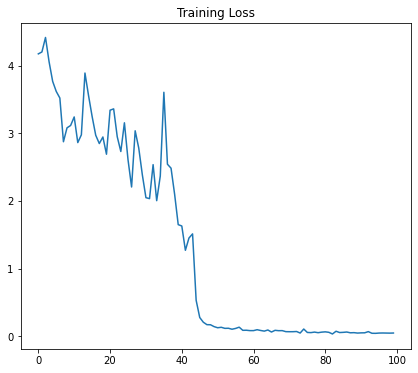

In [350]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

epchs = np.arange(len(loss))
# Plotting the loss 
fig, ax = plt.subplots(1)

fig.set_figheight(6)
fig.set_figwidth(7)
ax.plot(epchs, loss)
ax.set_title('Training Loss')

plt.show() 

In [351]:
Y_train_pred = np.zeros(Ytrain.shape)
Y_test_pred = np.zeros(Ytest.shape) 

for i in range(X_train.shape[1]):
    X_train_plt = X_train[:, i, :] # sending only one sample for prediction 
    Y_train_pred[:,i,:] = model.predict(X_train_plt, target_len = ow) 
    
for j in range(X_test.shape[1]):
    X_test_plt = X_test[:, j, :] # sending only one sample for prediction 
    Y_test_pred[:,j,:] = model.predict(X_test_plt, target_len = ow) 

print(Y_train_pred[:,1,:])    

[[ 0.72301972  0.36326432  2.85170388]
 [ 1.21441543  0.54105258  3.15037513]
 [ 1.51642752  0.58268076  3.21660995]
 ...
 [-3.23013663 -0.78452432 -0.48934418]
 [-3.24787259 -0.78149557 -0.43636394]
 [-3.26512766 -0.77783406 -0.38348463]]


# Plotting

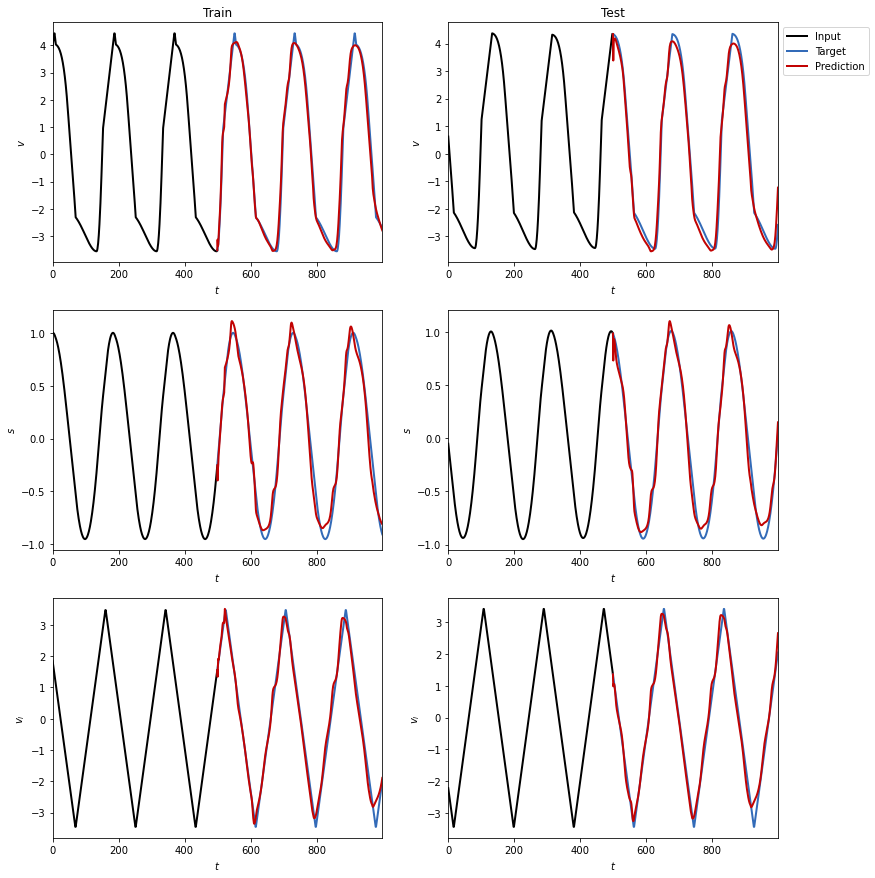

In [352]:
fig, ax = plt.subplots(3, 2, figsize = (13, 15))
winViz = 70

for ii in range(3):
    ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, winViz, ii], 'k', linewidth = 2, label = 'Input')
    ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, winViz, ii]], Ytrain[:, winViz, ii]]),
                  color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target') # Xtrain[-1, ii, 0] Initial Condition
    ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, winViz, ii]], Y_train_pred[:, winViz, ii]]),
                  color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
    ax[ii, 0].set_xlim([0, iw + ow - 1])

    # test set)
    ax[ii, 1].plot(np.arange(0, iw), Xtest[:, winViz, ii], 'k', linewidth = 2, label = 'Input')
    ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, winViz, ii]], Ytest[:, winViz, ii]]),
                  color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
    ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, winViz, ii]], Y_test_pred[:, winViz, ii]]),
                  color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
    ax[ii, 1].set_xlim([0, iw + ow - 1])
    if ii == 0:
      ax[ii, 0].set_xlabel('$t$')
      ax[ii, 0].set_ylabel('$v$')
      ax[ii, 1].set_xlabel('$t$')
      ax[ii, 1].set_ylabel('$v$')
    if ii == 1:
      ax[ii, 0].set_xlabel('$t$')
      ax[ii, 0].set_ylabel('$s$')
      ax[ii, 1].set_xlabel('$t$')
      ax[ii, 1].set_ylabel('$s$')
    if ii == 2:
      ax[ii, 0].set_xlabel('$t$')
      ax[ii, 0].set_ylabel('$v_l$')
      ax[ii, 1].set_xlabel('$t$')
      ax[ii, 1].set_ylabel('$v_l$')    

    if ii == 0:
      ax[ii, 0].set_title('Train')
      ax[ii, 1].legend(bbox_to_anchor=(1, 1))
      ax[ii, 1].set_title('Test')

In [692]:
print(Y_test_pred)

[[[22.69940567 24.8386116  22.71951485]
  [22.69940567 24.8386116  22.71951485]
  [22.69940567 24.8386116  22.71951485]
  ...
  [22.69940567 24.8386116  22.71951485]
  [22.69940567 24.8386116  22.71951485]
  [22.69940567 24.8386116  22.71951485]]

 [[22.90397453 25.20197678 22.98750114]
  [22.90397453 25.20197678 22.98750114]
  [22.90397453 25.20197678 22.98750114]
  ...
  [22.90397453 25.20197678 22.98750114]
  [22.90397453 25.20197678 22.98750114]
  [22.90397453 25.20197678 22.98750114]]

 [[22.93397903 25.25627136 23.02718163]
  [22.93397903 25.25627136 23.02718163]
  [22.93397903 25.25627136 23.02718163]
  ...
  [22.93397903 25.25627136 23.02718163]
  [22.93397903 25.25627136 23.02718163]
  [22.93397903 25.25627136 23.02718163]]

 ...

 [[22.93872833 25.26489449 23.03347397]
  [22.93872833 25.26489449 23.03347397]
  [22.93872833 25.26489449 23.03347397]
  ...
  [22.93872833 25.26489449 23.03347397]
  [22.93872833 25.26489449 23.03347397]
  [22.93872833 25.26489449 23.03347397]]

 [